In [ ]:
# Copyright (C) 2024  Jose Ángel Pérez Garrido
# 
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Prepare a segmentation model for evaluation

### Prepare the environment

In [4]:
# Variables
DATASET_PATH = "./datasets/TU-Graz"
SEED = 42 # Fixing the seed for PRNGs, to help reproducibility

In [5]:
import os

import numpy as np

import tensorflow as tf
import pandas as pd
import keras
from keras.models import Model
from keras.layers import *
from keras.applications.vgg16 import *
from keras.applications import InceptionV3

# Fixing the seed for PRNGs, to help reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Cityscapes Classes

Let us first explore what TU-Graz contains. As stated by the Institute of Computer Graphics and Vision in the [Dataset Overview](https://www.tugraz.at/index.php?id=22387), the complexity of the dataset is limited to 23 classes as listed below.

Therefore, we will use these methods to list all the classes appearing in this dataset, along with their related information:

In [6]:
class_file = pd.read_csv(str(DATASET_PATH + '/class_dict.csv'))

class_file

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [7]:
CLASSES = list(class_file["name"])
NUM_CLASSES = len(CLASSES)
COLORS = list(zip(class_file[" r"],class_file[" g"],class_file[" b"]))
COLORS_TF = tf.constant(COLORS, dtype=tf.int32) # TF constant corresponding to our color list

print(f"{CLASSES=}")
print(f"{COLORS=}")

CLASSES=['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']
COLORS=[(0, 0, 0), (128, 64, 128), (130, 76, 0), (0, 102, 0), (112, 103, 87), (28, 42, 168), (48, 41, 30), (0, 50, 89), (107, 142, 35), (70, 70, 70), (102, 102, 156), (254, 228, 12), (254, 148, 12), (190, 153, 153), (153, 153, 153), (255, 22, 96), (102, 51, 0), (9, 143, 150), (119, 11, 32), (51, 51, 0), (190, 250, 190), (112, 150, 146), (2, 135, 115), (255, 0, 0)]


2024-05-10 12:17:44.314535: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 12:17:44.341429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 12:17:44.341658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 12:17:44.343699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-10 12:17:44.343926: I external/local_xla/xla/stream_executor

### Data preprocessing

The procedure is defined below:

1. Resize each `400 x 600` image to a—`286 x 286`, or directly to `256 x 256` if data augmentation is not applied.
2. (With data augmentation) Randomly crop it to `256 x 256`.
3. (With data augmentation) Randomly flip the image horizontally i.e., left to right (random mirroring).
4. Convert label images to one-hot encoding.
5. Normalize the images to the `[-1, 1]` range (as indicated in [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks?tab=readme-ov-file#1-normalize-the-inputs)).

We employ an 80/10/10 split.

In [8]:
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

# The training set consist of 400 images
BUFFER_SIZE = 320

def load(image_file, type=tf.float32):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, type)
  real_image = tf.cast(real_image, type)

  return input_image, real_image

def resize(image, height, width, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR):
  image = tf.image.resize(image, [height, width],
                                method=method)

  return image

# Normalizing the images to [-1, 1]
def normalize(image):
  image = (image / 127.5) - 1

  return image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_WIDTH, IMG_HEIGHT, 3])

  return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image = resize(input_image, 286, 286)
  real_image = resize(real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

def convert_to_one_hot(image):
    # Create a "color reference" tensor from image_colors
    color_reference = tf.cast(tf.constant(COLORS), dtype=tf.float32)
    comp = tf.equal(image[..., None, :], color_reference)
    one_hot = tf.cast(tf.reduce_all(comp, axis=-1), dtype=tf.float32)

    return one_hot

In [9]:
# Load images without data augmentation
def load_image_seg(image_file):
  input_image, real_image = load(image_file)
  input_image = resize(input_image, IMG_WIDTH, IMG_HEIGHT)
  real_image = resize(real_image, IMG_WIDTH, IMG_HEIGHT)
  input_image = convert_to_one_hot(input_image)
  real_image = normalize(real_image)

  return real_image, input_image

# Load images without data augmentation
def load_image_seg_da(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image = convert_to_one_hot(input_image)
  real_image = normalize(real_image)

  return real_image, input_image

In [10]:
# Network hyper-parameters:
batch_size     = 16
num_epochs     = 150

In [11]:
# 80% training, 10% validation, and 10% test
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

dataset = tf.data.Dataset.list_files(str(DATASET_PATH + '/*.png'), shuffle=False)

# Calculate the sizes for each set
dataset_size = len(list(dataset))
train_size = int(train_percentage * dataset_size)
val_size = int(val_percentage * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

train_dataset = train_dataset.map(load_image_seg,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)

print("Training dataset size:",train_dataset.cardinality().numpy())

val_dataset = val_dataset.map(load_image_seg)
val_dataset = val_dataset.batch(batch_size)

print("Validation dataset size:",val_dataset.cardinality().numpy())

test_dataset = test_dataset.map(load_image_seg)
test_dataset = test_dataset.batch(batch_size)

print("Test dataset size:",test_dataset.cardinality().numpy())

Training dataset size: 20
Validation dataset size: 3
Test dataset size: 3


### FCN-8s architecture

FCN models have been developed for semantic segmentation. Based on VGG-16, they use this network as feature extractor, adding on top some layers to concatenate and upsample the feature maps into pixel-level predictions.

The FCN architecture is as follow:

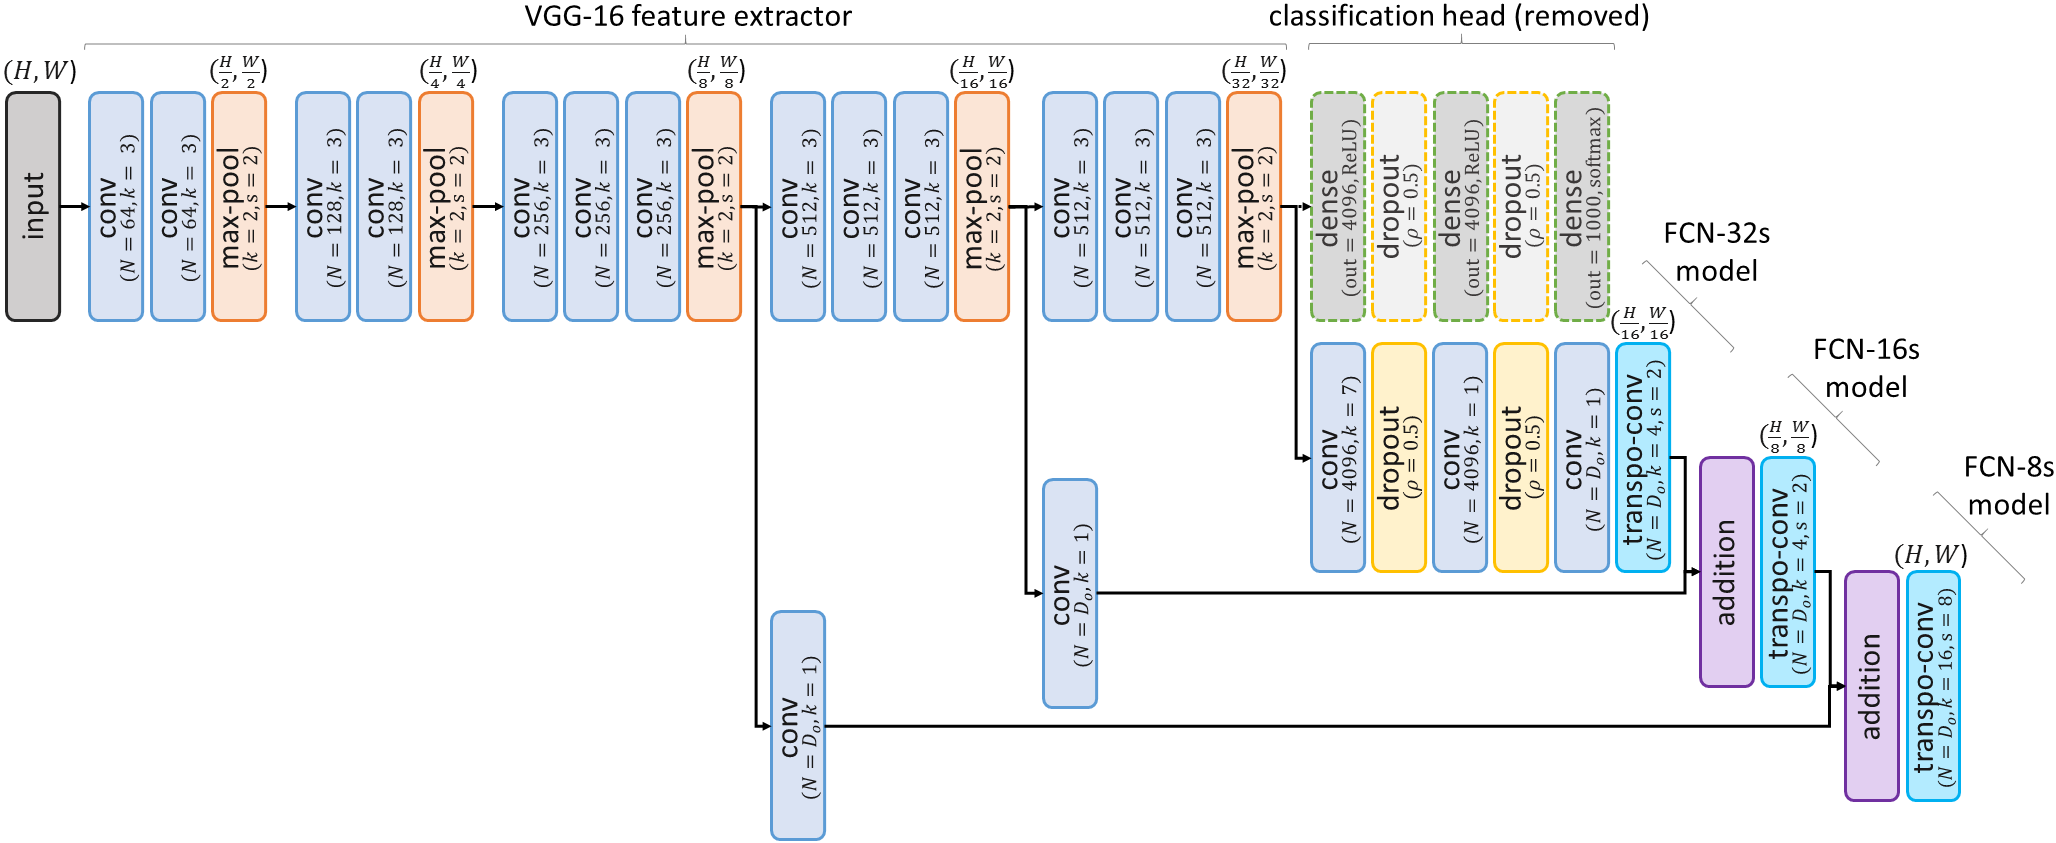

To purely focus on the architecture, we will once again use the Keras high-level API to create our model. Using the pre-trained VGG-16 network provided by Keras, we extend at according to the previous figure:

In [12]:
def fcn_8s(image_size, ch_in=3, ch_out=3):
    """
    Build a FCN-8s Keras model, with the VGG-16 layers pretrained on ImageNet.
    :param image_size:  Image size (H x W)
    :param ch_in:       Number of input channels
    :param ch_out:      Number of output channels
    :return:            Keras model
    """
    
    inputs = Input(shape=(*image_size, ch_in), name='input')

    # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    for layer in vgg16.layers:
        layer.trainable = False

    # Recovering the feature maps generated by each of the 3 final blocks:
    f3 = vgg16.get_layer('block3_pool').output  # shape: (28, 28, 256)
    f4 = vgg16.get_layer('block4_pool').output  # shape: (14, 14, 512)
    f5 = vgg16.get_layer('block5_pool').output  # shape: ( 7,  7, 512)
    f5.trainable = True

    # Replacing VGG dense layers by convolutions:
    f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
                      activation='relu')(f5)
    f5_drop1 = Dropout(0.5)(f5_conv1)
    f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
                      activation='relu')(f5_drop1)
    f5_drop2 = Dropout(0.5)(f5_conv2)
    f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f5_drop2)


    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5_conv3)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1, f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=ch_out, kernel_size=16, strides=8,
                              padding='same', activation="softmax")(merge2)
    
    fcn8s_model = Model(inputs, outputs)
    return fcn8s_model

In [13]:
seg_model = fcn_8s((IMG_WIDTH,IMG_HEIGHT), 3, NUM_CLASSES)
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input[0][0]']               
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

VGG is a rather heavy architecture (c.f. number of parameters). Nevertheless, most of the layers composing our model have been pre-trained on ImageNet already, which will simplify the training for our new task.

In [14]:
model_name = 'TU-Graz_fcn8s'
model_dir = os.path.join('models', model_name)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

Prepare and launch the TensorBoard viewer:

In [15]:
log_dir="logs_seg/"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4981), started 0:00:02 ago. (Use '!kill 4981' to kill it.)

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, f"{model_name}.keras")),
]

seg_model.compile(optimizer=optimizer, loss=tf.losses.CategoricalCrossentropy(), 
                    metrics=["accuracy", tf.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES)])

history = seg_model.fit(
    train_dataset,  epochs=num_epochs,validation_data=test_dataset,
    callbacks=callbacks)

Epoch 1/150


2024-05-10 12:18:32.402239: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-10 12:18:35.102222: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-10 12:18:43.280281: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4b38b4e1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-10 12:18:43.280337: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-10 12:18:43.286645: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715336323.397936  278914 device_compiler.h:186] Compiled cluster using XLA!  T

20/20 [==============================] - 41s 1s/step - loss: 2.5074 - accuracy: 0.3548 - one_hot_mean_io_u: 0.0544 - val_loss: 1.9194 - val_accuracy: 0.4605 - val_one_hot_mean_io_u: 0.0927
Epoch 2/150
20/20 [==============================] - 18s 814ms/step - loss: 1.6691 - accuracy: 0.5242 - one_hot_mean_io_u: 0.1125 - val_loss: 1.4729 - val_accuracy: 0.5806 - val_one_hot_mean_io_u: 0.1167
Epoch 3/150
20/20 [==============================] - 18s 816ms/step - loss: 1.4135 - accuracy: 0.5878 - one_hot_mean_io_u: 0.1407 - val_loss: 1.2529 - val_accuracy: 0.6452 - val_one_hot_mean_io_u: 0.1602
Epoch 4/150
20/20 [==============================] - 18s 814ms/step - loss: 1.2365 - accuracy: 0.6353 - one_hot_mean_io_u: 0.1661 - val_loss: 1.0936 - val_accuracy: 0.6764 - val_one_hot_mean_io_u: 0.1846
Epoch 5/150
20/20 [==============================] - 17s 800ms/step - loss: 1.1019 - accuracy: 0.6710 - one_hot_mean_io_u: 0.1916 - val_loss: 0.9934 - val_accuracy: 0.6963 - val_one_hot_mean_io_u: 0.

In [17]:
seg_model = keras.models.load_model(os.path.join(model_dir, f"{model_name}.keras"), safe_mode=False)
_, test_acc, test_iou = seg_model.evaluate(test_dataset)

print(f"{test_acc=}")
print(f"{test_iou=}")

3/3 [==============================] - 4s 1s/step - loss: 0.4122 - accuracy: 0.8684 - one_hot_mean_io_u: 0.5260
test_acc=0.8683521151542664
test_iou=0.5260190367698669


### With data augmentation

In [ ]:
# Network hyper-parameters:
batch_size     = 16
num_epochs     = 150

In [ ]:
# 80% training, 10% validation, and 10% test
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

dataset = tf.data.Dataset.list_files(str(DATASET_PATH + '/*.png'), shuffle=False)

# Calculate the sizes for each set
dataset_size = len(list(dataset))
train_size = int(train_percentage * dataset_size)
val_size = int(val_percentage * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

train_dataset = train_dataset.map(load_image_seg_da,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)

print("Training dataset size:",train_dataset.cardinality().numpy())

val_dataset = val_dataset.map(load_image_seg_da)
val_dataset = val_dataset.batch(batch_size)

print("Validation dataset size:",val_dataset.cardinality().numpy())

test_dataset = test_dataset.map(load_image_seg_da)
test_dataset = test_dataset.batch(batch_size)

print("Test dataset size:",test_dataset.cardinality().numpy())

Training dataset size: 20
Validation dataset size: 3
Test dataset size: 3


In [ ]:
seg_model = fcn_8s((IMG_WIDTH,IMG_HEIGHT), 3, NUM_CLASSES)

log_dir="logs_seg/"

model_name = 'TU-Graz_fcn8s_da'
model_dir = os.path.join('models', model_name)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, f"{model_name}.keras")),
]

seg_model.compile(optimizer=optimizer, loss=tf.losses.CategoricalCrossentropy(), 
                    metrics=["accuracy", tf.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES)])

history = seg_model.fit(
    train_dataset,  epochs=num_epochs,validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/150


2024-04-15 09:35:27.853421: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 23s 980ms/step - loss: 2.4677 - accuracy: 0.3485 - one_hot_mean_io_u_1: 0.0444 - val_loss: 1.7771 - val_accuracy: 0.5133 - val_one_hot_mean_io_u_1: 0.0663
Epoch 2/150
20/20 [==============================] - 17s 799ms/step - loss: 1.6523 - accuracy: 0.5207 - one_hot_mean_io_u_1: 0.0851 - val_loss: 1.6194 - val_accuracy: 0.5273 - val_one_hot_mean_io_u_1: 0.0986
Epoch 3/150
20/20 [==============================] - 21s 958ms/step - loss: 1.4189 - accuracy: 0.5905 - one_hot_mean_io_u_1: 0.1125 - val_loss: 1.3983 - val_accuracy: 0.5962 - val_one_hot_mean_io_u_1: 0.1180
Epoch 4/150
20/20 [==============================] - 21s 963ms/step - loss: 1.3165 - accuracy: 0.6165 - one_hot_mean_io_u_1: 0.1276 - val_loss: 1.2872 - val_accuracy: 0.6203 - val_one_hot_mean_io_u_1: 0.1414
Epoch 5/150
20/20 [==============================] - 20s 944ms/step - loss: 1.2038 - accuracy: 0.6515 - one_hot_mean_io_u_1: 0.1473 - val_loss: 1.0919 - val_accuracy: 0.6839 - val_

In [ ]:
seg_model = keras.models.load_model(os.path.join(model_dir, f"{model_name}.keras"), safe_mode=False)
_, test_acc, test_iou = seg_model.evaluate(test_dataset)

print(f"{test_acc=}")
print(f"{test_iou=}")

3/3 [==============================] - 2s 212ms/step - loss: 0.7177 - accuracy: 0.7736 - one_hot_mean_io_u_1: 0.3506
test_acc=0.7735759615898132
test_iou=0.35057541728019714


## U-Net

Let's see if we can improve the segmentation performance using a U-net instead of a FCN-8s.

In [ ]:
# Network hyper-parameters:
batch_size     = 16
num_epochs     = 150

In [ ]:
# 80% training, 10% validation, and 10% test
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

dataset = tf.data.Dataset.list_files(str(DATASET_PATH + '/*.png'), shuffle=False)

# Calculate the sizes for each set
dataset_size = len(list(dataset))
train_size = int(train_percentage * dataset_size)
val_size = int(val_percentage * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

train_dataset = train_dataset.map(load_image_seg,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)

print("Training dataset size:",train_dataset.cardinality().numpy())

val_dataset = val_dataset.map(load_image_seg)
val_dataset = val_dataset.batch(batch_size)

print("Validation dataset size:",val_dataset.cardinality().numpy())

test_dataset = test_dataset.map(load_image_seg)
test_dataset = test_dataset.batch(batch_size)

print("Test dataset size:",test_dataset.cardinality().numpy())

Training dataset size: 20
Validation dataset size: 3
Test dataset size: 3


In [ ]:
def unet_conv_block(x, filters, kernel_size=3, batch_norm=True, dropout=False,
                    name_prefix="enc_", name_suffix=0):
    """
    Pass the input tensor through 2 Conv layers with LeakyReLU activation + opt. through
    BatchNorm and Dropout layers.
    :param x:                       Input tensor.
    :param filters:                 Number of filters.
    :param kernel_size:             Kernel size.
    :param batch_norm:              Flag to apply batch normalization.
    :param dropout:                 Flag to apply dropout.
    :param name_prefix:             Prefix for the layers' names.
    :param name_suffix:             Suffix for the layers' names.
    :return:                        Transformed tensor.
    """
    name_fn = lambda layer, num: '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)

    # First convolution:
    x = Conv2D(filters, kernel_size=kernel_size, activation=None,
               kernel_initializer='he_normal', padding='same',
               name=name_fn('conv', 1))(x)
    if batch_norm:
        x = BatchNormalization(name=name_fn('bn', 1))(x)
    x = LeakyReLU(alpha=0.3, name=name_fn('act', 1))(x)
    if dropout:
        x = Dropout(0.2, name=name_fn('drop', 1))(x)

    # Second convolution:
    x = Conv2D(filters, kernel_size=kernel_size, activation=None,
               kernel_initializer='he_normal', padding='same',
               name=name_fn('conv', 2))(x)
    if batch_norm:
        x = BatchNormalization(name=name_fn('bn', 2))(x)
    x = LeakyReLU(alpha=0.3, name=name_fn('act', 2))(x)

    return x


def unet_deconv_block(x, filters, kernel_size=2, strides=2, batch_norm=True, dropout=False,
                      name_prefix="dec_", name_suffix=0):
    """
    Pass the input tensor through 1 Conv layer and 1 transposed (de)Conv layer with LeakyReLU
    activation + opt. through BatchNorm and Dropout layers.
    :param x:                       Input tensor.
    :param filters:                 Number of filters.
    :param kernel_size:             Kernel size.
    :param strides:                 Strides for transposed convolution.
    :param batch_norm:              Flag to apply batch normalization.
    :param dropout:                 Flag to apply dropout.
    :param name_prefix:             Prefix for the layers' names.
    :param name_suffix:             Suffix for the layers' names.
    :return:                        Transformed tensor.
    """
    name_fn = lambda layer, num: '{}{}{}-{}'.format(name_prefix, layer, name_suffix, num)

    # First convolution:
    x = Conv2D(filters, kernel_size=kernel_size, activation=None,
               kernel_initializer='he_normal', padding='same',
               name=name_fn('conv', 1))(x)
    if batch_norm:
        x = BatchNormalization(name=name_fn('bn', 1))(x)
    x = LeakyReLU(alpha=0.3, name=name_fn('act', 1))(x)
    if dropout:
        x = Dropout(0.2, name=name_fn('drop', 1))(x)

    # Second (de)convolution:
    x = Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides,
                        activation=None, kernel_initializer='he_normal',
                        padding='same', name=name_fn('conv', 2))(x)
    if batch_norm:
        x = BatchNormalization(name=name_fn('bn', 2))(x)
    x = LeakyReLU(alpha=0.3, name=name_fn('act', 2))(x)

    return x


# As the dimensions of our images may not be normalized/even, it is possible that after 
# downsampling and upsampling, we do not reobtain the original size (with a difference 
# of +/- 1px).
# To avoid the problems this may cause, we define a layer to slightly resize the generated
# image to the dimensions of the target one:
ResizeToSame = lambda name: Lambda(
    lambda images: tf.image.resize(images[0], tf.shape(images[1])[1:3]),
    # `images` is a tuple of 2 tensors.
    # We resize the first image tensor to the shape of the 2nd
    name=name)


def unet(x, out_channels=3, layer_depth=4, filters_orig=32, kernel_size=4,
         batch_norm=True, final_activation='sigmoid'):
    """
    Pass the tensor through a trainable UNet.
    :param x:                       Input tensor.
    :param out_channels:            Number of output channels.
    :param layer_depth:             Number of convolutional blocks vertically stacked.
    :param filters_orig:            Number of filters for the 1st block (then multiplied by 2 
                                    every block).
    :param kernel_size:             Kernel size for layers.
    :param batch_norm:              Flag to apply batch normalization.
    :param final_activation:        Name/function for the last activation.
    :return:                        Output tensor.
    """
    # Encoding layers:
    filters = filters_orig
    outputs_for_skip = []
    for i in range(layer_depth):
        conv_block = unet_conv_block(x, filters, kernel_size,
                                     batch_norm=batch_norm, name_suffix=i)
        outputs_for_skip.append(conv_block)

        x = MaxPooling2D(2)(conv_block)

        filters = min(filters * 2, 512)

    # Bottleneck layers:
    x = unet_conv_block(x, filters, kernel_size, name_suffix='btleneck')

    # Decoding layers:
    for i in range(layer_depth):
        filters = max(filters // 2, filters_orig)

        use_dropout = i < (layer_depth - 2)
        deconv_block = unet_deconv_block(x, filters, kernel_size,
                                         batch_norm=batch_norm,
                                         dropout=use_dropout, name_suffix=i)

        shortcut = outputs_for_skip[-(i + 1)]
        deconv_block = ResizeToSame(
            name='resize_to_same{}'.format(i))([deconv_block, shortcut])

        x = concatenate([deconv_block, shortcut], axis=-1,
                        name='dec_conc{}'.format(i))

    x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',
               padding='same', name='dec_out1')(x)
    x = Dropout(0.3, name='drop_out1')(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',
               padding='same', name='dec_out2')(x)
    x = Dropout(0.3, name='drop_out2')(x)
    x = Conv2D(filters=out_channels, kernel_size=1, activation=final_activation,
               padding='same', name='dec_output')(x)

    return x

In [ ]:
# Network hyper-parameters:
kernel_size    = 4
filters_orig   = 32
layer_depth    = 3
use_batch_norm = batch_size > 1

inputs = Input(shape=(256, 256, 3), name='input')
outputs = unet(inputs, out_channels=NUM_CLASSES, 
               layer_depth=layer_depth, filters_orig=filters_orig, 
               kernel_size=kernel_size, batch_norm=use_batch_norm,
               final_activation="softmax" # we define our U-Net to output logits.
              )

seg_model = Model(inputs, outputs)

seg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", tf.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES)])

seg_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 enc_conv0-1 (Conv2D)        (None, 256, 256, 32)         1568      ['input[0][0]']               
                                                                                                  
 enc_bn0-1 (BatchNormalizat  (None, 256, 256, 32)         128       ['enc_conv0-1[0][0]']         
 ion)                                                                                             
                                                                                                  
 enc_act0-1 (LeakyReLU)      (None, 256, 256, 32)         0         ['enc_bn0-1[0][0]']     

 dec_bn2-1 (BatchNormalizat  (None, 128, 128, 32)         128       ['dec_conv2-1[0][0]']         
 ion)                                                                                             
                                                                                                  
 dec_act2-1 (LeakyReLU)      (None, 128, 128, 32)         0         ['dec_bn2-1[0][0]']           
                                                                                                  
 dec_conv2-2 (Conv2DTranspo  (None, 256, 256, 32)         16416     ['dec_act2-1[0][0]']          
 se)                                                                                              
                                                                                                  
 dec_bn2-2 (BatchNormalizat  (None, 256, 256, 32)         128       ['dec_conv2-2[0][0]']         
 ion)                                                                                             
          

In [ ]:
model_name = 'TU-Graz_unet'
model_dir = os.path.join('models', model_name)

log_dir="logs_seg/"

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, f"{model_name}.keras")),
]

In [ ]:
history = seg_model.fit(
    train_dataset,  epochs=num_epochs,validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/150


2024-04-14 14:37:00.732436: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dec_drop0-1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 22s 45ms/step - loss: 2.1673 - accuracy: 0.4130 - one_hot_mean_io_u_2: 0.0459 - val_loss: 1.5053 - val_accuracy: 0.5532 - val_one_hot_mean_io_u_2: 0.0582
Epoch 2/150
320/320 [==============================] - 16s 43ms/step - loss: 1.7602 - accuracy: 0.5061 - one_hot_mean_io_u_2: 0.0697 - val_loss: 1.4061 - val_accuracy: 0.5960 - val_one_hot_mean_io_u_2: 0.0863
Epoch 3/150
320/320 [==============================] - 15s 43ms/step - loss: 1.5976 - accuracy: 0.5539 - one_hot_mean_io_u_2: 0.0853 - val_loss: 1.4923 - val_accuracy: 0.5376 - val_one_hot_mean_io_u_2: 0.0808
Epoch 4/150
320/320 [==============================] - 15s 43ms/step - loss: 1.4420 - accuracy: 0.6002 - one_hot_mean_io_u_2: 0.0985 - val_loss: 1.4617 - val_accuracy: 0.5880 - val_one_hot_mean_io_u_2: 0.1021
Epoch 5/150
320/320 [==============================] - 15s 43ms/step - loss: 1.3722 - accuracy: 0.6195 - one_hot_mean_io_u_2: 0.1088 - val_loss: 1.6932 - val_accuracy: 0.4895 -

In [ ]:
seg_model = keras.models.load_model(os.path.join(model_dir, f"{model_name}.keras"), safe_mode=False)
_, test_acc, test_iou = seg_model.evaluate(test_dataset)

print(f"{test_acc=}")
print(f"{test_iou=}")

40/40 [==============================] - 2s 20ms/step - loss: 1.5587 - accuracy: 0.5486 - one_hot_mean_io_u: 0.1002
test_acc=0.5486301183700562
test_iou=0.10022569447755814


In [ ]:
# Network hyper-parameters:
batch_size     = 16
num_epochs     = 150

In [ ]:
# Split the dataset
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)

train_dataset = train_dataset.map(load_image_seg_da,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(batch_size)

print("Training dataset size:",train_dataset.cardinality().numpy())

val_dataset = val_dataset.map(load_image_seg_da)
val_dataset = val_dataset.batch(batch_size)

print("Validation dataset size:",val_dataset.cardinality().numpy())

test_dataset = test_dataset.map(load_image_seg_da)
test_dataset = test_dataset.batch(batch_size)

print("Test dataset size:",test_dataset.cardinality().numpy())

Training dataset size: 20
Validation dataset size: 3
Test dataset size: 3


In [ ]:
# Network hyper-parameters:
kernel_size    = 4
filters_orig   = 32
layer_depth    = 3
use_batch_norm = batch_size > 1

inputs = Input(shape=(256, 256, 3), name='input')
outputs = unet(inputs, out_channels=NUM_CLASSES, 
               layer_depth=layer_depth, filters_orig=filters_orig, 
               kernel_size=kernel_size, batch_norm=use_batch_norm,
               final_activation="softmax" # we define our U-Net to output logits.
              )

seg_model = Model(inputs, outputs)

seg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", tf.metrics.OneHotMeanIoU(num_classes=NUM_CLASSES)])

seg_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 enc_conv0-1 (Conv2D)        (None, 256, 256, 32)         1568      ['input[0][0]']               
                                                                                                  
 enc_bn0-1 (BatchNormalizat  (None, 256, 256, 32)         128       ['enc_conv0-1[0][0]']         
 ion)                                                                                             
                                                                                                  
 enc_act0-1 (LeakyReLU)      (None, 256, 256, 32)         0         ['enc_bn0-1[0][0]']     

                                                                                                  
 dec_out1 (Conv2D)           (None, 256, 256, 32)         32800     ['dec_conc2[0][0]']           
                                                                                                  
 drop_out1 (Dropout)         (None, 256, 256, 32)         0         ['dec_out1[0][0]']            
                                                                                                  
 dec_out2 (Conv2D)           (None, 256, 256, 32)         16416     ['drop_out1[0][0]']           
                                                                                                  
 drop_out2 (Dropout)         (None, 256, 256, 32)         0         ['dec_out2[0][0]']            
                                                                                                  
 dec_output (Conv2D)         (None, 256, 256, 24)         792       ['drop_out2[0][0]']           
          

In [ ]:
model_name = 'TU-Graz_unet_da'
model_dir = os.path.join('models', model_name)

log_dir="logs_seg/"

callbacks = [
    # Callback to interrupt the training if the validation loss stops improving:
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss',
                                     restore_best_weights=True),
    # Callback to log the graph, losses and metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True),
    # Callback to save the model  specifying the epoch and val-loss in the filename:
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(model_dir, f"{model_name}.keras")),
]

In [ ]:
history = seg_model.fit(
    train_dataset,  epochs=num_epochs,validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/150


2024-04-14 15:09:04.774660: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dec_drop0-1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


320/320 [==============================] - 22s 46ms/step - loss: 2.1209 - accuracy: 0.4173 - one_hot_mean_io_u_5: 0.0443 - val_loss: 1.5705 - val_accuracy: 0.5926 - val_one_hot_mean_io_u_5: 0.0578
Epoch 2/150
320/320 [==============================] - 16s 45ms/step - loss: 1.7568 - accuracy: 0.5122 - one_hot_mean_io_u_5: 0.0631 - val_loss: 1.5219 - val_accuracy: 0.5665 - val_one_hot_mean_io_u_5: 0.0754
Epoch 3/150
320/320 [==============================] - 16s 44ms/step - loss: 1.5992 - accuracy: 0.5541 - one_hot_mean_io_u_5: 0.0758 - val_loss: 1.5331 - val_accuracy: 0.5508 - val_one_hot_mean_io_u_5: 0.0779
Epoch 4/150
320/320 [==============================] - 16s 44ms/step - loss: 1.4696 - accuracy: 0.5859 - one_hot_mean_io_u_5: 0.0848 - val_loss: 1.6385 - val_accuracy: 0.5442 - val_one_hot_mean_io_u_5: 0.0856
Epoch 5/150
320/320 [==============================] - 16s 45ms/step - loss: 1.3781 - accuracy: 0.6117 - one_hot_mean_io_u_5: 0.0939 - val_loss: 1.5418 - val_accuracy: 0.5587 -

In [ ]:
seg_model = keras.models.load_model(os.path.join(model_dir, f"{model_name}.keras"), safe_mode=False)
_, test_acc, test_iou = seg_model.evaluate(test_dataset)

print(f"{test_acc=}")
print(f"{test_iou=}")

2024-04-15 12:58:06.274846: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


3/3 [==============================] - 16s 2s/step - loss: 1.4274 - accuracy: 0.5847 - one_hot_mean_io_u_5: 0.1058
test_acc=0.5847129821777344
test_iou=0.10575371980667114
